In [6]:
points

array([[ 0.37207645, -0.05386647, -0.1073141 ],
       [ 0.36826754, -0.05412292, -0.10702634],
       [ 0.36826754, -0.05595155, -0.10848077],
       ...,
       [ 0.30314648, -0.1568041 , -0.16758667],
       [ 0.31586182, -0.13868539, -0.12213587],
       [ 0.31586182, -0.16942944, -0.12213587]], dtype=float32)

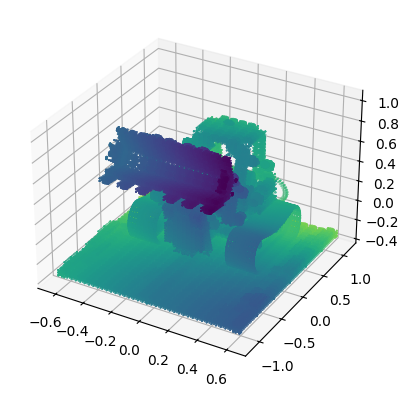

In [4]:
viz_points(points)

In [5]:
# compute and output the bounds of the points

def compute_bounds(points):
    return np.min(points, axis=0), np.max(points, axis=0)

min_bound, max_bound = compute_bounds(points)

min_bound, max_bound

(array([-0.63778746, -1.1400161 , -0.34465563], dtype=float32),
 array([0.6337443, 1.1487377, 1.002206 ], dtype=float32))

In [26]:
# create a loadnelf lego dataset
from lodnelf.data.lego_dataset import LegoDataset

train_dataset = LegoDataset("../data/lego", split="train", limit=1)

In [7]:
train_dataset[0]

(tensor([-0.0538,  3.8455,  1.2081]),
 tensor([ 0.3340, -0.9418,  0.0390]),
 tensor([0., 0., 0., 0.]))

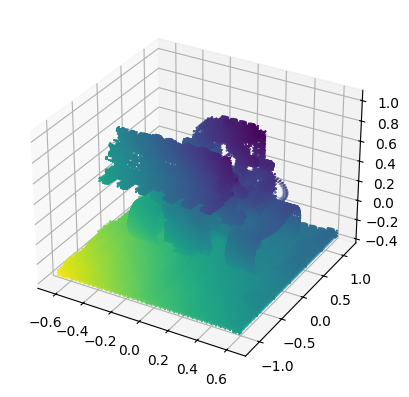

In [31]:
viz_data_point_dir(train_dataset[0])

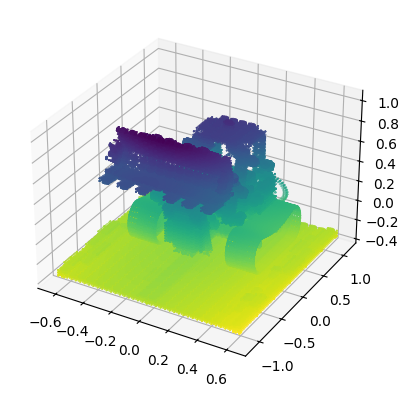

In [32]:
viz_data_point_dir(train_dataset[1231])

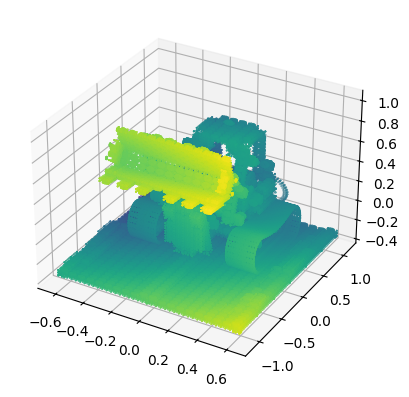

In [33]:
viz_data_point_dir(train_dataset[len(train_dataset) - 1])

In [9]:
selected_points = stratified_sampling(points, 256 * 2)

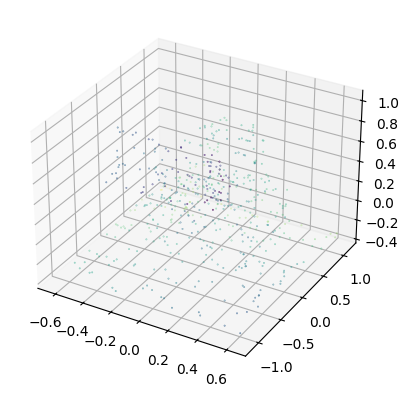

In [10]:
viz_points(selected_points)

In [12]:
256 * 2

512

In [13]:
from torch.utils.data import DataLoader
from lodnelf.data.lego_dataset import LegoDataset

train_dataset = LegoDataset("../data/lego", split="val", limit=1)

dataloader = DataLoader(train_dataset, batch_size=32)

In [56]:
# create the model
model = PointBasedNelf(selected_points, 64, [128, 128, 128], alpha=0.8)

batch = next(iter(dataloader))

model(batch).shape

torch.Size([64, 4])

In [69]:
from lodnelf.geometry.compute_ray_space_ray_directions import (
    compute_cam_space_ray_directions,
)
import torch


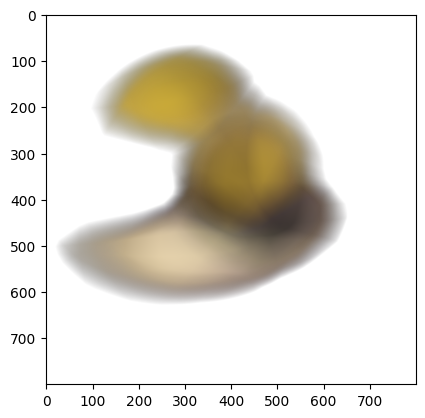

In [70]:
print_holdout_view(model)

In [73]:
# train the model

from torch.utils.data import DataLoader
from torch import optim
from lodnelf.data.lego_dataset import LegoDataset
from tqdm import tqdm

VAL_FREQUENCY = 3
HOLDOUT_FREQUENCY = 1

# create the dataset
train_dataset = LegoDataset("../data/lego", split="train")
val_dataset = LegoDataset("../data/lego", split="val")

# create the dataloader
N_TRAIN_SAMPLES = 50000
dataloader = DataLoader(
    train_dataset,
    batch_size=64,
    sampler=torch.utils.data.RandomSampler(
        train_dataset, replacement=False, num_samples=N_TRAIN_SAMPLES
    ),
)
N_VAL_SAMPLES = 10000
val_dataloader = DataLoader(
    val_dataset,
    batch_size=64,
    sampler=torch.utils.data.RandomSampler(
        train_dataset, replacement=False, num_samples=N_VAL_SAMPLES
    ),
)

# create the optimizer
optimizer = optim.Adam(model.parameters(), lr=1e-3)

# create the loss function
loss_fn = nn.MSELoss()

# train the model
for epoch in range(10):
    running_loss = 0
    model.train()
    for data_point in tqdm(dataloader):
        ray_origin, ray_dir_world, col = data_point
        optimizer.zero_grad()

        output = model(data_point)

        loss = loss_fn(output, col)
        running_loss += loss.item()

        loss.backward()
        optimizer.step()
    print(f"Epoch {epoch}, Loss {running_loss / N_TRAIN_SAMPLES}")

    if epoch % HOLDOUT_FREQUENCY == 0:
        print_holdout_view(model)

    if epoch % VAL_FREQUENCY == 0:
        with torch.no_grad():
            model.eval()
            running_loss = 0
            for data_point in val_dataloader:
                ray_origin, ray_dir_world, col = data_point

                output = model(data_point)

                loss = loss_fn(output, col)
                running_loss += loss.item()
            print(f"Validation Loss {running_loss / N_VAL_SAMPLES}")

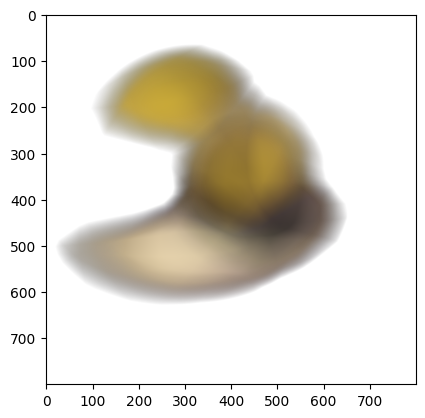

In [67]:
torch.stack(model_output).numpy()

array([[0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       ...,
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.]], dtype=float32)

In [62]:
rgba.reshape(800, 800, 5))

SyntaxError: unmatched ')' (3123590151.py, line 1)

 16%|█▌        | 1009/6400 [00:07<00:41, 130.70it/s]

KeyboardInterrupt: 

In [70]:
rgba

[tensor([0.0000, 0.2353, 0.0000, 0.0000]),
 tensor([0.0000, 0.2358, 0.0000, 0.0000]),
 tensor([0.0000, 0.2363, 0.0000, 0.0000]),
 tensor([0.0000, 0.2368, 0.0000, 0.0000]),
 tensor([0.0000, 0.2373, 0.0000, 0.0000]),
 tensor([0.0000, 0.2378, 0.0000, 0.0000]),
 tensor([0.0000, 0.2383, 0.0000, 0.0000]),
 tensor([0.0000, 0.2388, 0.0000, 0.0000]),
 tensor([0.0000, 0.2393, 0.0000, 0.0000]),
 tensor([0.0000, 0.2398, 0.0000, 0.0000]),
 tensor([0.0000, 0.2403, 0.0000, 0.0000]),
 tensor([0.0000, 0.2408, 0.0000, 0.0000]),
 tensor([0.0000, 0.2413, 0.0000, 0.0000]),
 tensor([0.0000, 0.2418, 0.0000, 0.0000]),
 tensor([0.0000, 0.2423, 0.0000, 0.0000]),
 tensor([0.0000, 0.2428, 0.0000, 0.0000]),
 tensor([0.0000, 0.2433, 0.0000, 0.0000]),
 tensor([0.0000, 0.2438, 0.0000, 0.0000]),
 tensor([0.0000, 0.2443, 0.0000, 0.0000]),
 tensor([0.0000, 0.2448, 0.0000, 0.0000]),
 tensor([0.0000, 0.2453, 0.0000, 0.0000]),
 tensor([0.0000, 0.2458, 0.0000, 0.0000]),
 tensor([0.0000, 0.2464, 0.0000, 0.0000]),
 tensor([0.

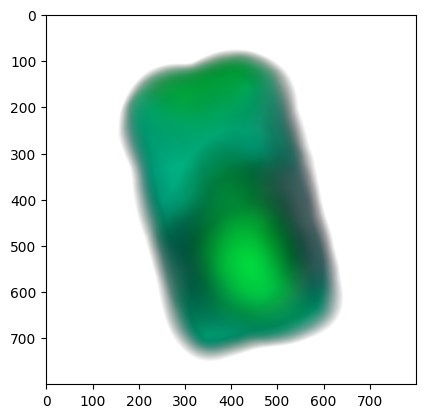

In [42]:
# reshape tensor to image
rgba = torch.cat(rgba, dim=0)


TypeError: cat() received an invalid combination of arguments - got (Tensor, dim=int), but expected one of:
 * (tuple of Tensors tensors, int dim, *, Tensor out)
 * (tuple of Tensors tensors, name dim, *, Tensor out)


In [47]:
28480 ** 0.5

168.7601848778319

In [245]:
# test the model on a validation datapoint

train_dataset = LegoDataset("../data/lego", split="val", limit=1)

dataloader = DataLoader(train_dataset, batch_size=64)

rgba = []

with torch.no_grad():
    for data_point in dataloader:
        ray_origin, ray_dir_world, col = data_point

        output = model(data_point)

        rgba.extend(output.detach().numpy())